In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm
import catboost
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Data load

In [4]:
df = pd.read_csv('/kaggle/input/real-time-advertisers-auction/Dataset.csv')
df.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


In [5]:
df.shape

(567291, 17)

# Target variable create

In [6]:
def weird_division(n, d):
    return n / d if d else 0

In [7]:
df['CPM'] = df.apply(lambda x: weird_division(((x['total_revenue'] * 100)),
                                              x['measurable_impressions']) * 1000,
                     axis=1)

In [8]:
df.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,CPM
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1,0.0
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1,0.0
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1,0.0
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1,0.0
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1,0.0


In [9]:
df[df['CPM'] < 0]

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,CPM
109144,2019-06-24 00:00:00,351,10,113,2,79,3487,8,58,1,19,5179,22,-0.1542,8,22,1,-700.909091


In [10]:
df = df[df['CPM'] >= 0]
df.shape

(567290, 18)

# NaN check

In [11]:
df.isna().sum()

date                       0
site_id                    0
ad_type_id                 0
geo_id                     0
device_category_id         0
advertiser_id              0
order_id                   0
line_item_type_id          0
os_id                      0
integration_type_id        0
monetization_channel_id    0
ad_unit_id                 0
total_impressions          0
total_revenue              0
viewable_impressions       0
measurable_impressions     0
revenue_share_percent      0
CPM                        0
dtype: int64

# EDA

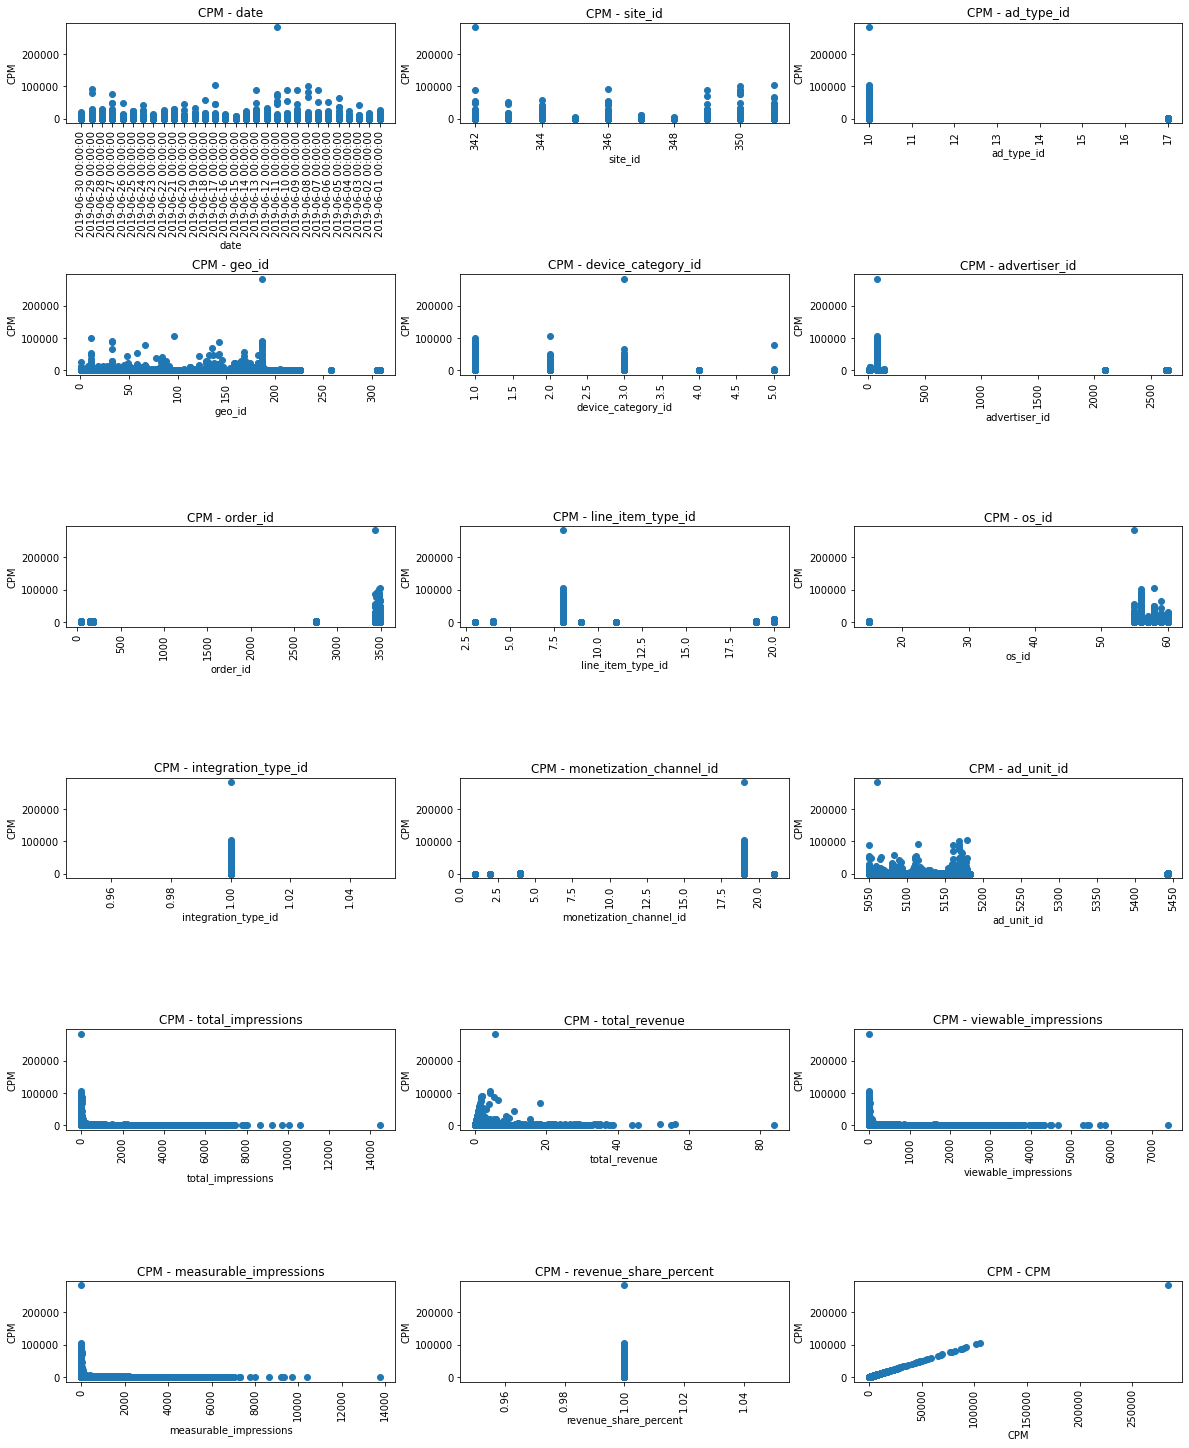

In [12]:
fig, axs = plt.subplots(6, 3, figsize=(20, 25), facecolor='w', edgecolor='k')

plt.subplots_adjust(hspace=1.5)

axs = axs.ravel()

for i in range(len(df.columns)):
    axs[i].set_title('CPM - ' + df.columns[i])
    axs[i].scatter(df[df.columns[i]], df['CPM'])
    axs[i].set_ylabel('CPM')
    axs[i].set_xlabel(df.columns[i])
    axs[i].tick_params(axis='x', rotation=90)

#axs[17].set_axis_off()

# Create features

In [13]:
df['View/measurable'] = df.apply(lambda x: weird_division(x['viewable_impressions'],
                                                          x['measurable_impressions']),
                                 axis=1,
                                )

# Drop features

In [14]:
df_droped = df.drop(['revenue_share_percent', # 1 unique value
                     'integration_type_id', # 1 unique value
                     'total_revenue', # CPM depend
                     'measurable_impressions', # CPM depend, 'View/measurable' depend
                     'viewable_impressions', # 'View/measurable',
                     ],
                     axis=1,
                    )

In [15]:
df_droped.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,CPM,View/measurable
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,4,5174,16,0.0,0.125
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,4,5174,6,0.0,0.000
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,4,5174,4,0.0,0.000
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,4,5174,4,0.0,0.000
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,19,5138,4,0.0,0.000


In [16]:
df_droped.shape

(567290, 14)

# Create new features

In [17]:
# Convert date_time column to datetime type
df_droped['date'] = pd.to_datetime(df_droped['date'])

# Number of day in the week
df_droped['day_number'] = df_droped['date'].dt.day

# Name of day in the week
df_droped['day_week'] = df_droped['date'].dt.day_name()

# Weekend flag
df_droped['is_weekend'] = df_droped['day_week'].apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)

In [18]:
df_droped.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,CPM,View/measurable,day_number,day_week,is_weekend
0,2019-06-30,351,10,187,2,84,3473,19,60,4,5174,16,0.0,0.125,30,Sunday,1
1,2019-06-30,351,10,187,2,84,3473,19,58,4,5174,6,0.0,0.000,30,Sunday,1
2,2019-06-30,351,10,147,2,84,3473,19,60,4,5174,4,0.0,0.000,30,Sunday,1
3,2019-06-30,351,10,147,2,84,3473,19,58,4,5174,4,0.0,0.000,30,Sunday,1
4,2019-06-30,348,10,147,3,79,3463,20,59,19,5138,4,0.0,0.000,30,Sunday,1


# Train-test split

In [19]:
# All days in data
np.sort(df_droped['date'].unique())

array(['2019-06-01T00:00:00.000000000', '2019-06-02T00:00:00.000000000',
       '2019-06-03T00:00:00.000000000', '2019-06-04T00:00:00.000000000',
       '2019-06-05T00:00:00.000000000', '2019-06-06T00:00:00.000000000',
       '2019-06-07T00:00:00.000000000', '2019-06-08T00:00:00.000000000',
       '2019-06-09T00:00:00.000000000', '2019-06-10T00:00:00.000000000',
       '2019-06-11T00:00:00.000000000', '2019-06-12T00:00:00.000000000',
       '2019-06-13T00:00:00.000000000', '2019-06-14T00:00:00.000000000',
       '2019-06-15T00:00:00.000000000', '2019-06-16T00:00:00.000000000',
       '2019-06-17T00:00:00.000000000', '2019-06-18T00:00:00.000000000',
       '2019-06-19T00:00:00.000000000', '2019-06-20T00:00:00.000000000',
       '2019-06-21T00:00:00.000000000', '2019-06-22T00:00:00.000000000',
       '2019-06-23T00:00:00.000000000', '2019-06-24T00:00:00.000000000',
       '2019-06-25T00:00:00.000000000', '2019-06-26T00:00:00.000000000',
       '2019-06-27T00:00:00.000000000', '2019-06-28

In [20]:
def data_splitter(df, train_valid_range=['2019-06-01 00:00:00', '2019-06-21 00:00:00'], valid_size=0.1): 
    # Train/val data separation
    mask = (df['date'] >= train_valid_range[0]) & (df['date'] <= train_valid_range[1])
    df_train_valid = df[mask]
    df_train_valid = df_train_valid[df_train_valid['CPM'] < df_train_valid['CPM'].quantile(0.95)]
    y_train_ = df_train_valid['CPM'].values
    X_train_ = df_train_valid.drop(['CPM', 'date'], axis=1).values
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_,
                                                          y_train_,
                                                          test_size=valid_size,
                                                          random_state=42,
                                                          shuffle=True,
                                                         )
    # Test data separation
    mask = (df['date'] >= '2019-06-22 00:00:00')
    df_test = df[mask]
    df_test = df_test[df_test['CPM'] < df_test['CPM'].quantile(0.95)]
    y_test = df_test['CPM'].values
    X_test = df_test.drop(['CPM', 'date'], axis=1).values
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test 

In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = data_splitter(df_droped)

In [22]:
assert X_train.shape[1] == X_valid.shape[1] == X_test.shape[1]

In [23]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape 

((338787, 15), (37643, 15), (162222, 15), (338787,), (37643,), (162222,))

# Model create

In [24]:
ctb = catboost.CatBoostRegressor(iterations=1000,
                                 learning_rate=0.1,
                                 random_seed=42,
                                 depth=10,
                                 task_type="CPU",
                                 loss_function='RMSE',
                                 l2_leaf_reg=5,
                                 use_best_model=True,
                                 bagging_temperature=1000,
                                 border_count=255,
                                )

# Fit model on train data and validate on valid data

In [25]:
ctb.fit(X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        plot=True,
        early_stopping_rounds=10,
        cat_features=[13],
        verbose=False,
       )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Results of training

In [26]:
print('Number of trees: {}'.format(ctb.best_iteration_))
print('Best MSE on train: {}, on validation: {}'.format(ctb.best_score_['learn']['RMSE']**2,
                                                        ctb.best_score_['validation']['RMSE']**2,
                                                        ),
     )

Number of trees: 810
Best MSE on train: 1801.8474705967317, on validation: 2032.310242173658


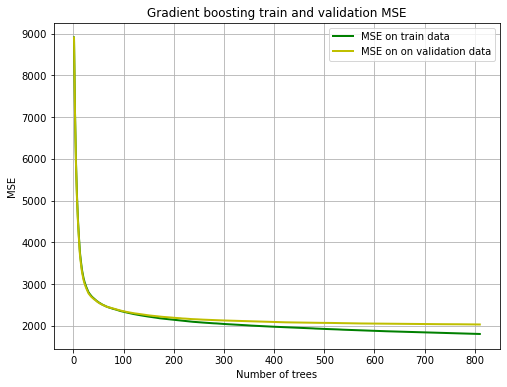

In [27]:
# Reserve plot if the cell with catboost training plot is not displayed in Kaggle notebooks

plt.figure(figsize=(8, 6))

results = pd.DataFrame({'train_MSE': np.power(ctb.evals_result_['learn']['RMSE'], 2)[0:ctb.best_iteration_],
                        'validation_MSE': np.power(ctb.evals_result_['validation']['RMSE'], 2)[0:ctb.best_iteration_],
                        'trees_number': np.arange(1, ctb.best_iteration_+1, 1),
                       },
                      )

g = sns.lineplot(data=results,
                 x='trees_number',
                 y='train_MSE',
                 color="g",
                 linewidth=2,
                );
g = sns.lineplot(data=results,
                 x='trees_number',
                 y='validation_MSE',
                 color="y",
                 linewidth=2,
                );
g.set(xlabel='Number of trees',
      ylabel='MSE',
      title='Gradient boosting train and validation MSE',
     );
g.grid();
g.legend(loc='best',
         labels=['MSE on train data', 'MSE on on validation data'],
        );

# Predictions

In [28]:
train_preds = ctb.predict(X_train)
valid_preds = ctb.predict(X_valid)
test_preds = ctb.predict(X_test)

# Metrics

In [29]:
print('--------------------')
print('MSE score:')
print('--------------------')
print('Train MSE: {:.3f}'.format(mean_squared_error(y_train, train_preds)))
print('Valid MSE: {:.3f}'.format(mean_squared_error(y_valid, valid_preds)))
print('Test MSE: {:.3f}'.format(mean_squared_error(y_test, test_preds)))
print('\n--------------------')
print('R2 score:')
print('--------------------')
print('Train R2: {:.3f} %'.format(100 * r2_score(y_train, train_preds)))
print('Valid R2: {:.3f} %'.format(100 * r2_score(y_valid, valid_preds)))
print('Test R2: {:.3f} %'.format(100 * r2_score(y_test, test_preds)))

--------------------
MSE score:
--------------------
Train MSE: 1807.081
Valid MSE: 2032.310
Test MSE: 2713.520

--------------------
R2 score:
--------------------
Train R2: 82.176 %
Valid R2: 79.983 %
Test R2: 74.875 %
